## Topic modeling using neural attention for aspect extraction

Plan for the project:
1. Text exploration.
2. Text preprocessing using different tools, including byte pair encoding (BPE).
3. Training model.
4. Evaluation of results.    
    4.1. Evaluation by coherense score.    
    4.2. Evaluation by text classifacation.
5. Discription of future steps for the project.

## 1. Loading data 

In [49]:

import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
from importlib import reload 
import text_preprocess
from text_preprocess import  preprocess , remove_rare_words, process_words_for_LDA
from spacy.lemmatizer import Lemmatizer, Lookups
from spacy.lang.ru import RussianLemmatizer
from pprint import pprint
# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.models import Word2Vec

import pymorphy2


import matplotlib.pyplot as plt    
    
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('russian')
stop.remove('не')

from model import get_aspect_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Graphs
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# папка текущего файла

PATH = os.path.abspath(os.getcwd())

# Папка исходных файлов
DATA_PATH = os.path.join(PATH,'data')

DATA_PATH


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'C:\\Users\\ivan\\YandexDisk\\DS\\NLP course Huawei\\Project NLP\\data'

In [52]:
reload(text_preprocess)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Extending stop words: 449it [00:00, 447219.78it/s]

Number of stop words:  600


<module 'text_preprocess' from 'C:\\Users\\ivan\\YandexDisk\\DS\\NLP course Huawei\\Project NLP\\text_preprocess.py'>

Dataset consists of 2 separate dataframes with positive and negative twits. Each dataframe consist more then 100000 rows.


Loading **positive** twits:

In [53]:
pos_df = pd.read_csv(os.path.join(DATA_PATH,'positive.csv'), header = None, sep=';')

# column titles
cols = ['id',
       'tdate',
       'tmane',
       'ttext',
       'ttype',
       'trep',
       'trtw',
       'tfav',
       'tstcount',
       'tfol',
       'tfrien',
       'listcount'
       ]

pos_df.columns = cols
pos_df.head(5)

,id,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


Loading **negative** twits:    

In [54]:
neg_df = pd.read_csv(os.path.join(DATA_PATH,'negative.csv'), header = None, sep=';')

neg_df.columns = cols
neg_df.head(5)

,id,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


For further work we will concatenate dataframes with only text and its sentiment, and mix rows:

In [55]:
pos_df['sentiment'] = 1
neg_df['sentiment'] = 0
train_df = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=12).reset_index(drop=True)
train_df = train_df[['ttext', 'sentiment']]
train_df

,ttext,sentiment
0,"@AlinaaaaLi Единственный,чей твиттер я нашла:3...",1
1,"RT @pilipchuk1809: Сидели ели в столовке, заод...",1
2,Сфоткай типо крутой такой :D http://t.co/5BcIv...,1
3,"@BilanOfficial "" КОЗЕРОГ Сегодня вам удастся в...",1
4,"#misfits О, этот неловкий момент :D http://t.c...",1
...,...,...
226829,"19 935!? Твиттер, да ты сдурел, у меня их долж...",0
226830,"RT @mokomosicus: Мы бухали, даже когда у нас н...",1
226831,@jam2k Пораньше выехал вообще без проблем добр...,1
226832,"@Ovcharenko95 да, я видела, очень точно было п...",0


As we can see corpus is very raw and need to be preprocessed. Steps for preprocessing are described below.


# 2. Data exploration


Let's have look at length of the twits and amount of words in twit

In [56]:
train_df['twit_len'] = train_df['ttext'].map(len)

# filter text list if there are no spaces
train_df['words_num'] = [len(list(filter(lambda x: x!='' , text.split(' ')))) for text in train_df['ttext']]

In [57]:
train_df['twit_len'].describe()

count    226834.000000
mean         81.129892
std          28.013056
min           8.000000
25%          58.000000
50%          74.000000
75%         101.000000
max         189.000000
Name: twit_len, dtype: float64

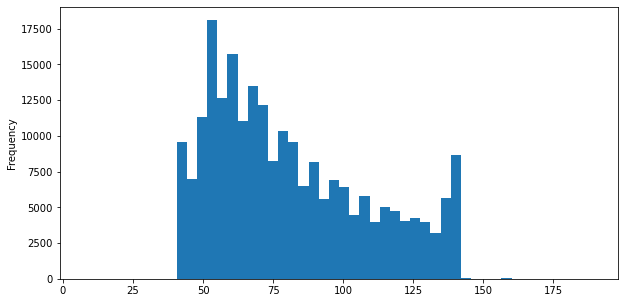

In [58]:
train_df['twit_len'].plot(kind='hist', bins=50, figsize=(10,5));

In [59]:
train_df['words_num'].describe()

count    226834.000000
mean         12.087923
std           4.811285
min           1.000000
25%           8.000000
50%          11.000000
75%          15.000000
max          37.000000
Name: words_num, dtype: float64

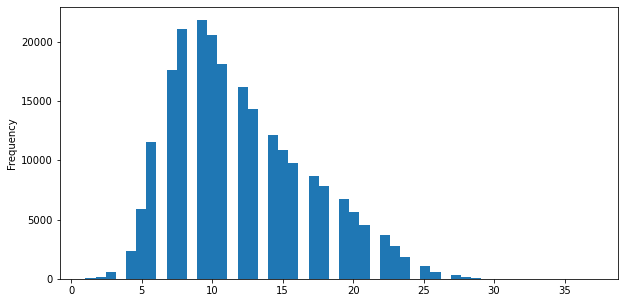

In [60]:
train_df['words_num'].plot(kind='hist', bins=50, figsize=(10,5));

## 3. Text preprocess

In this step the prepering processes are:
1. Convert characters to lower case.
2. Remove words with characters length less than 3.
3. Remove non-alphabetic symbols.
4. Byte pair encoding of unknown words.
5. Convert different emoticons to several types.

In [61]:
#reload(text_preprocess)

corpus = train_df['ttext']

train_df['clean_text'] = preprocess(corpus)

train_df['clean_twit_len'] = train_df['clean_text'].map(len)

# filter text list if there are no spaces
train_df['clean_words_num'] = [len(list(filter(lambda x: x!='' , text.split(' ')))) for text in train_df['clean_text']]

text preprocessing: 100%|█████████████████████████████████████████████████████| 226834/226834 [05:51<00:00, 645.62it/s]


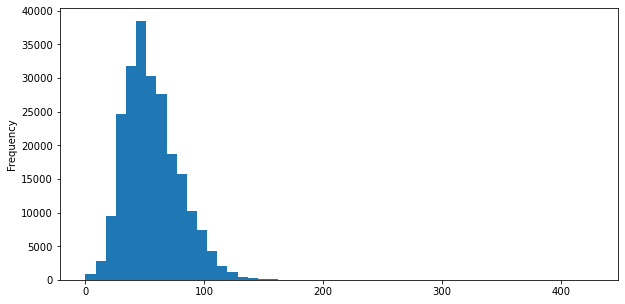

In [62]:
train_df['clean_twit_len'].plot(kind='hist', bins=50, figsize=(10,5));

As we can see distribution became more normal than it was before preprocessing

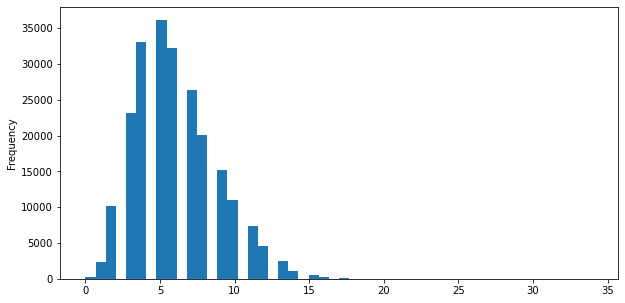

In [63]:
train_df['clean_words_num'].plot(kind='hist', bins=50, figsize=(10,5));

Removing rows with number of words more than 20:

In [64]:
train_df= train_df[train_df['clean_words_num']<20]

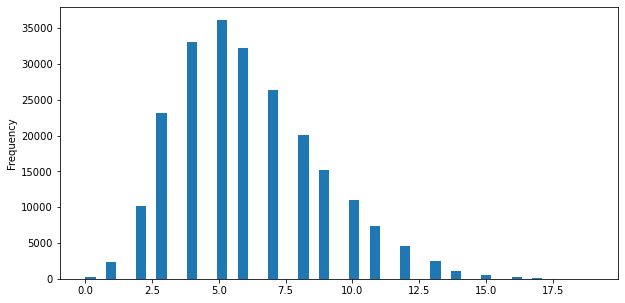

In [65]:
train_df['clean_words_num'].plot(kind='hist', bins=50, figsize=(10,5));

In [66]:
train_df.head(15)

,ttext,sentiment,twit_len,words_num,clean_text,clean_twit_len,clean_words_num
0,"@AlinaaaaLi Единственный,чей твиттер я нашла:3...",1,79,9,единственный твиттер найти веселыйсмайлик виде...,82,9
1,"RT @pilipchuk1809: Сидели ели в столовке, заод...",1,92,11,сидеть столовка заодно квеста придумать веселы...,54,6
2,Сфоткай типо крутой такой :D http://t.co/5BcIv...,1,51,6,сфоткай крутой веселыйсмайлик,29,3
3,"@BilanOfficial "" КОЗЕРОГ Сегодня вам удастся в...",1,137,20,козерог удаться выйти состояние депрессия пров...,91,10
4,"#misfits О, этот неловкий момент :D http://t.c...",1,58,7,неловкий момент веселыйсмайлик,30,3
5,"@Summer_day_day оо это плохо (\nя хорошо,сижу ...",0,77,11,плохо грустныйсмайлик сидеть перевозить слово ...,53,6
6,"К предыдущему :) У меня есть друзья с авто, ...",1,120,20,предыдущий веселыйсмайлик друг авто исповедова...,81,9
7,"@depressator у меня нет близкой подруги, котор...",0,67,11,близкий подруга пошлый грустныйсмайлик,38,4
8,RT @chelovekonline: Жириновский предлагает отм...,0,132,12,жириновский предлагать отменить новогодний кан...,99,9
9,RT @Restrukt58: @polk1247u56 @DZHIGURDA12 сайт...,1,56,6,сайт радовать веселыйсмайлик,28,3


We will remove words that appear very rare in the corpus since they are unique and can not give us enough information about topics

In [67]:
corpus = train_df['clean_text'].values

# number is min count values to cut words
corpus_clean = remove_rare_words(corpus, 20, 30)# num of appearence of rare words and n most frequent tokens

Creating out corpus: 100%|█████████████████████████████████████████████████| 226803/226803 [00:00<00:00, 241812.32it/s]


#### Checking results

Creating dataframe from dictionary to check result how much words in dictionary

In [68]:
dic = corpora.Dictionary(corpus_clean)

#dictionary word:word id
dict_words = dic.token2id

#dictionary word id: number of word
dic_id_nums = dic.cfs

In [69]:
dict_df = pd.DataFrame.from_dict({'token':list(dict_words.keys()), 'count_word': list(dic_id_nums.values())})
len(dict_df)

6314

In [70]:
dict_df.sort_values(by='count_word', ascending=False)

,token,count_word
741,посмотреть,2331
314,ночь,2312
382,работа,2297
253,никто,2234
197,понять,2231
...,...,...
2606,урал,20
4838,славно,20
5787,веселух,20
6049,борец,20


## 3.2 Text preprocess for LDA model

Creating bigrams:

In [72]:
corpus_preprocessed = process_words_for_LDA(corpus_clean)

In [73]:
len(corpus_preprocessed)

226803

Clean dataset if there are empty docs

In [75]:
corpus_preprocessed = [doc for doc in corpus_preprocessed if len(doc)!=0]

Check length of corpus after cleaning:


In [76]:
len(corpus_preprocessed)

217258

## 4.Model implementation

### 4.1. LDA model

In [78]:
# Create Dictionary
id2word = corpora.Dictionary(corpus_preprocessed)

# Create Corpus: Term Document Frequency
corpus_freq = [id2word.doc2bow(text) for text in corpus_preprocessed]

# Create word-id dictionary
word2id = id2word.token2id

Let's find optimum number of topics by calculating coherense coefficient:

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc = 'Model working'):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=12,
                                           update_every=1,
                                           chunksize=10,
                                           passes=3,
                                           alpha='symmetric',
                                           iterations=50,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
%%time
# Num of topics to choose
start=2
limit=20
step=2


model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus_freq, 
                                                        texts=corpus_for_LDA, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Model working:   0%|                                                                             | 0/9 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [ ]:
max_cv = max(coherence_values)
best_lda_model = model_list[coherence_values.index(max_cv)]
best_lda_model.save('best_lda_model')

In [30]:
%%time 
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus_freq,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=14,
                                           #update_every=1,
                                           chunksize=10,
                                           passes=3,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True,
                                           dtype=np.float64,
                                           workers = 3)

pprint(lda_model.print_topics())

KeyboardInterrupt: 

In [31]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_freq, dictionary=id2word)
vis

NameError: name 'lda_model' is not defined

Result of topic modeling with LDA:
1. Optimizing number of topics by higher coherence score was reached optimum number 14. Maximum score is 0.44.
2. For some group of words we can form topic, but for most of them it is not vivid.


### 4.2. Attention based model

In [79]:
VOCAB_SIZE = len(id2word)
EMB_SIZE = 200
N_ASPECTS = 14
MAX_LEN = 30
NEG_SAMPLES = 20
BATCH_SIZE = 50
seed = 4

In [ ]:
# w2v_model = Word2Vec(sentences=[one_txt], size=200, window=10, min_count=10, workers=3, negative=5)
w2v_model = Word2Vec(sentences=corpus_preprocessed, size=200, window=5, min_count=5, workers=3, batch_words=10)

if not os.path.exists(PATH + '/pre_trained_model/'):
    os.makedirs(PATH + '/pre_trained_model/')

w2v_model.save(PATH + '/pre_trained_model/model_param_my')

In [ ]:
list(w2v_model.wv.vocab.keys())[0]

Let's check how good enough word2vec model:

In [ ]:
w2v_model.most_similar('гибдд')

In [72]:
np_embeddings = np.zeros(shape=[VOCAB_SIZE, EMB_SIZE], dtype=np.float64)

for word, vec in w2v_model.wv.vocab.items():
    vector = w2v_model.wv.get_vector(word)
    idx = word2id.get(word, 1)
    np_embeddings[idx] = vector

In [180]:
np_embeddings[0,:]

array([ 0.58046091, -0.5080719 ,  0.2217437 , -0.02409325,  0.03027211,
        0.21300595, -0.24829389,  0.04124511,  0.10144607,  0.15158959,
       -0.60270119, -0.30086964,  0.29846945,  0.3655169 , -0.23861469,
       -0.21774176,  0.37084886, -0.36292168, -0.45522884, -0.5865081 ,
        0.04393405, -0.29436395,  0.50134021,  0.00760685,  0.25868461,
        0.49199906,  0.06857179, -0.06439271, -0.75686944, -0.24353349,
        0.08813462,  0.79811764, -1.08821106, -0.18916614, -0.17071921,
       -0.70849317,  0.37765869, -0.28277054, -0.18408227, -0.387454  ,
        0.72704208,  0.10010694, -0.13361716,  0.11645491,  0.10853064,
        0.24904753,  0.35930973, -0.60280496,  0.52158344, -0.2594707 ,
        0.39484838,  0.68975806,  0.68660444, -0.23813707, -0.17036557,
       -0.57748491, -0.08383751,  0.24079515,  0.12511776, -0.11529636,
       -0.61539388, -0.15280421, -0.01660089, -0.10044867, -0.24360123,
        0.03971481,  0.17943379, -0.08759924, -0.50791121, -0.14

In [73]:
np_embeddings_norm = np_embeddings / np.linalg.norm(np_embeddings, axis=-1, keepdims=True)

<ipython-input-73-b62f83956ac9>:1: RuntimeWarning: invalid value encountered in true_divide
  np_embeddings_norm = np_embeddings / np.linalg.norm(np_embeddings, axis=-1, keepdims=True)


In [74]:
np_embeddings_norm[0] = np.zeros_like(np_embeddings_norm[0])

In [83]:
np_embeddings.shape

(11438, 200)

### 4.3 Aspect matrix

In [92]:
aspect_matrix

array([[ 0.13767918, -0.01905021,  0.04898615, ...,  0.0857032 ,
         0.014983  ,  0.0390065 ],
       [ 0.13007763, -0.04604626,  0.01870821, ...,  0.09690237,
         0.01932184,  0.06483544],
       [ 0.13960267, -0.01985216,  0.04926921, ...,  0.08529034,
         0.01553794,  0.04075563],
       ...,
       [ 0.07032481, -0.01280481,  0.00990978, ...,  0.03982073,
         0.06964493,  0.07123461],
       [ 0.01522193, -0.03180458, -0.00348832, ...,  0.10985265,
        -0.02152068,  0.01222712],
       [ 0.09874591, -0.0670449 , -0.01074867, ...,  0.09143032,
         0.01820285,  0.08012112]])

In [86]:
aspect_matrix = get_aspect_matrix(np_embeddings, N_ASPECTS)

In [108]:
labels = []
tokens = []

for word in w2v_model.wv.vocab:
    tokens.append(w2v_model.wv[word])
    labels.append(word)

In [142]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    z = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        z.append(value[2])
    plt.figure(figsize=(16, 16)).gca(projection='3d')
    for i in range(len(x)):
        plt.scatter(x[i],y[i], z[i],cmap='tab10')
       
        #ax.set_xlabel('pca-one')
        #ax.set_ylabel('pca-two')
        #ax.set_zlabel('pca-three')
    plt.show()



C:\Users\ivan\anaconda3\lib\site-packages\matplotlib\collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


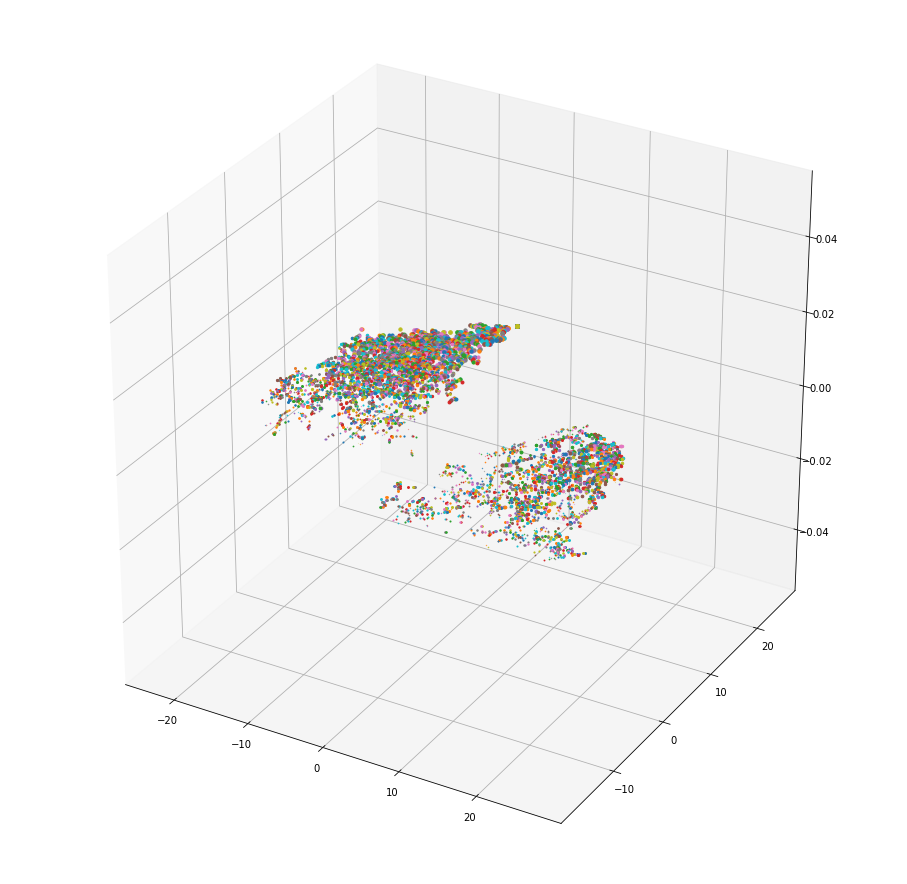

In [143]:
tsne_plot(w2v_model)

In [146]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=14)
km.fit(np_embeddings_norm)
clusters = km.cluster_centers_

        # L2 normalization
norm_aspect_matrix = clusters / np.linalg.norm(clusters, axis=-1, keepdims=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [148]:
np_embeddings

array([[ 0.58046091, -0.5080719 ,  0.2217437 , ...,  0.15575299,
        -0.04386089,  0.88418764],
       [ 0.22070658, -0.18527567, -0.06941174, ...,  0.24750881,
         0.02342354,  0.215855  ],
       [ 0.24636672, -0.31791154, -0.04385097, ...,  0.45812234,
         0.00539693,  0.33131483],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### 5. Training model


### 5.1 Pretrained embeddings

In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
TORCH_DEVICE ='cpu'# 'cuda' # 'cpu'

In [ ]:
torch.device(TORCH_DEVICE)
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 

In [ ]:
pretrained_embeddings = torch.FloatTensor(np_embeddings_norm)
pretrained_embeddings.shape

### 5.2 Text to torch

In [ ]:
def texts_to_seq(texts_to_ids, maxlen=MAX_LEN):
    pad_token = 0
    sequences = [
        [pad_token]*(maxlen - len(txt)) + txt[-maxlen:]
        for txt in texts_to_ids
        if len(txt) != 0
    ]
    return torch.tensor(sequences, dtype=torch.long, device=TORCH_DEVICE)

In [ ]:
padded_texts = texts_to_seq(indexed_texts, maxlen=MAX_LEN)
padded_test = texts_to_seq(indexed_test, maxlen=MAX_LEN)

In [ ]:
pos_neg_loader = DataLoader(
    dataset=PosNegDataset(padded_texts, neg_size=NEG_SAMPLES),
    batch_size=BATCH_SIZE,
    shuffle=True,
#     num_workers=4,
)

### 6. Testing model

In [ ]:
from torch.utils.data import DataLoader
from model import PosNegDataset

### 7. Results evaluation